The purpose of this notebook is to select dates for which to load in the TREx images. These are determined by using certain GM activity parameters from the OMNIWeb database. Using the 1 HR resolution data, looking at KP*10 Index, AE Index, DsT Index and Scalar B (IMF components, Bx,By,Bz). 

Kp*10: Tells us the overall level of Geomagnetic Activity
AE: Auroral Electrojet presence (global, quantitative measure of auroral zone magnetic activity)
DsT Index: Disturbance Storm Time index (measure of the strength of the Earth's ring current)
Scalar B: Measure of IMF. Typically, we use changes in Bz to help with auroral forecasting. Scalar B is a representation of the magnetic field overall.

In [34]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from matplotlib.lines import Line2D

In [35]:
column_names = ['Year', 'DOY', 'Hour','Scalar B, nT','Kp*10 index','Dst-index, nT','AE-index, nT']    
omni_hr = pd.read_csv('omni_aurora.txt', sep = r'\s+', names = column_names, header = None)

In [36]:
omni_hr

,Year,DOY,Hour,"Scalar B, nT",Kp*10 index,"Dst-index, nT","AE-index, nT"
0,2023,213,0,5.2,20,-12,326
1,2023,213,1,5.3,20,-11,346
2,2023,213,2,5.3,20,-9,261
3,2023,213,3,3.6,17,-5,156
4,2023,213,4,2.2,17,-1,58
...,...,...,...,...,...,...,...
20683,2025,343,19,999.9,13,-10,9999
20684,2025,343,20,999.9,13,-13,9999
20685,2025,343,21,999.9,13,-13,9999
20686,2025,343,22,999.9,13,-11,9999


In [41]:
omni_hr['Year'] = omni_hr['Year'].astype(int)
omni_hr['DOY'] = omni_hr['DOY'].astype(int)
omni_hr['Hour'] = omni_hr['Hour'].astype(int)

# Create TimeStamps column 
omni_hr['TimeStamps'] = pd.to_datetime(
    omni_hr['Year'].astype(str) + omni_hr['DOY'].astype(str).str.zfill(3), 
    format='%Y%j', errors='coerce'   # errors='coerce' will set invalid dates to NaT
) + pd.to_timedelta(omni_hr['Hour'], unit='h')

# Convert Kp*10 index to Kp index
omni_hr['Kp Index'] = omni_hr['Kp*10 index'] / 10

# Map Kp index to color
def kp_to_color(kp):
    if kp < 5:
        return 'green'
    elif kp < 6:
        return 'yellow'
    elif kp < 7:
        return '#CCCC00'  
    elif kp < 8:
        return 'orange'
    elif kp < 9:  # G4
        return 'red'
    elif kp == 9.0:  # G5
        return '#8B0000'  
    else:
        return 'gray'  # fallback color

omni_hr['Color'] = omni_hr['Kp Index'].apply(kp_to_color)

# Clean invalid values
omni_hr['Scalar B, nT'] = omni_hr['Scalar B, nT'].replace(9.999e+02, np.nan)
omni_hr['Dst-index, nT'] = omni_hr['Dst-index, nT'].replace(9999, np.nan)
omni_hr['Dst-index, nT'] = omni_hr['Dst-index, nT'].replace(9.999e+02, np.nan)
omni_hr['AE-index, nT'] = omni_hr['AE-index, nT'].replace(9999, np.nan)

omni_hr


,Year,DOY,Hour,"Scalar B, nT",Kp*10 index,"Dst-index, nT","AE-index, nT",TimeStamps,Kp Index,Color
0,2023,213,0,5.2,20,-12,326.0,2023-08-01 00:00:00,2.0,green
1,2023,213,1,5.3,20,-11,346.0,2023-08-01 01:00:00,2.0,green
2,2023,213,2,5.3,20,-9,261.0,2023-08-01 02:00:00,2.0,green
3,2023,213,3,3.6,17,-5,156.0,2023-08-01 03:00:00,1.7,green
4,2023,213,4,2.2,17,-1,58.0,2023-08-01 04:00:00,1.7,green
...,...,...,...,...,...,...,...,...,...,...
20683,2025,343,19,NaN,13,-10,NaN,2025-12-09 19:00:00,1.3,green
20684,2025,343,20,NaN,13,-13,NaN,2025-12-09 20:00:00,1.3,green
20685,2025,343,21,NaN,13,-13,NaN,2025-12-09 21:00:00,1.3,green
20686,2025,343,22,NaN,13,-11,NaN,2025-12-09 22:00:00,1.3,green


In [49]:
def GMActivity_range(omni_data, start_dt, end_dt, x_tick_vals, x_tick_labels, save_fig_str):
    """
    Visualizes geomagnetic activity over an arbitrary datetime range 
    (works for multi-year spans, e.g. 2023–2025).

    Parameters:
    ----------
    omni_data : pandas.DataFrame
        Must contain:
        'TimeStamps', 'Kp Index', 'Color', 
        'AE-index, nT', 'Dst-index, nT', 'Scalar B, nT'

    start_dt : str or datetime
        Start datetime (inclusive)

    end_dt : str or datetime
        End datetime (exclusive)

    x_tick_vals : list of datetime
        X-axis ticks

    x_tick_labels : list of str
        Labels for ticks

    save_fig_str : str or empty
        Path to save figure, or '' to skip saving.
    """

    # Convert to datetime if strings
    start_dt = pd.to_datetime(start_dt)
    end_dt   = pd.to_datetime(end_dt)

    # Filter full dataset by timestamp range
    mnths = omni_data[
        (omni_data["TimeStamps"] >= start_dt) &
        (omni_data["TimeStamps"] <  end_dt)
    ].copy()

    # Clean inf values
    mnths = mnths.replace([np.inf, -np.inf], np.nan)

    # Initialize Figure
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 15), sharex=True)

    # 1: KP Index
    ax[0].bar(
        x=mnths['TimeStamps'],
        height=mnths['Kp Index'],
        color=mnths['Color'],
        width=1/24
    )
    ax[0].set_ylabel("KP Index", fontsize=14)
    ax[0].set_ylim(0, 10)
    ax[0].set_title('Kp Index vs Time', fontsize=16)
    ax[0].grid()

    # AE Index
    sns.lineplot(x=mnths['TimeStamps'], y=mnths['AE-index, nT'], ax=ax[1], color='lightseagreen')
    ax[1].set_ylabel("AE Index (nT)", fontsize=14)
    ax[1].set_title('AE Index vs Time', fontsize=16)
    ax[1].grid()

    # Dst Index
    sns.lineplot(x=mnths['TimeStamps'], y=mnths['Dst-index, nT'], ax=ax[2], color='purple')
    ax[2].set_ylabel("Dst Index (nT)", fontsize=14)
    ax[2].set_title('Dst Index vs Time', fontsize=16)
    ax[2].grid()

    # Magnetic Field Strength
    sns.lineplot(x=mnths['TimeStamps'], y=mnths['Scalar B, nT'], ax=ax[3], color='royalblue')
    ax[3].set_ylabel("B Scalar (nT)", fontsize=14)
    ax[3].set_title('Magnetic Field vs Time', fontsize=16)
    ax[3].grid()

    # X-axis ticks
    ax[-1].set_xticks(pd.to_datetime(x_tick_vals))
    ax[-1].set_xticklabels(x_tick_labels)

    for axis in ax[:-1]:
        axis.tick_params(labelbottom=True)

    ax[-1].tick_params(labelsize=14) # WHY WONT THIS WORKKK
        

    fig.tight_layout()
    if save_fig_str:
        plt.savefig(save_fig_str)
    plt.show()


In [50]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*use_inf_as_na option is deprecated.*"
)

In [51]:
# OVERALL RESIZING
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12) 

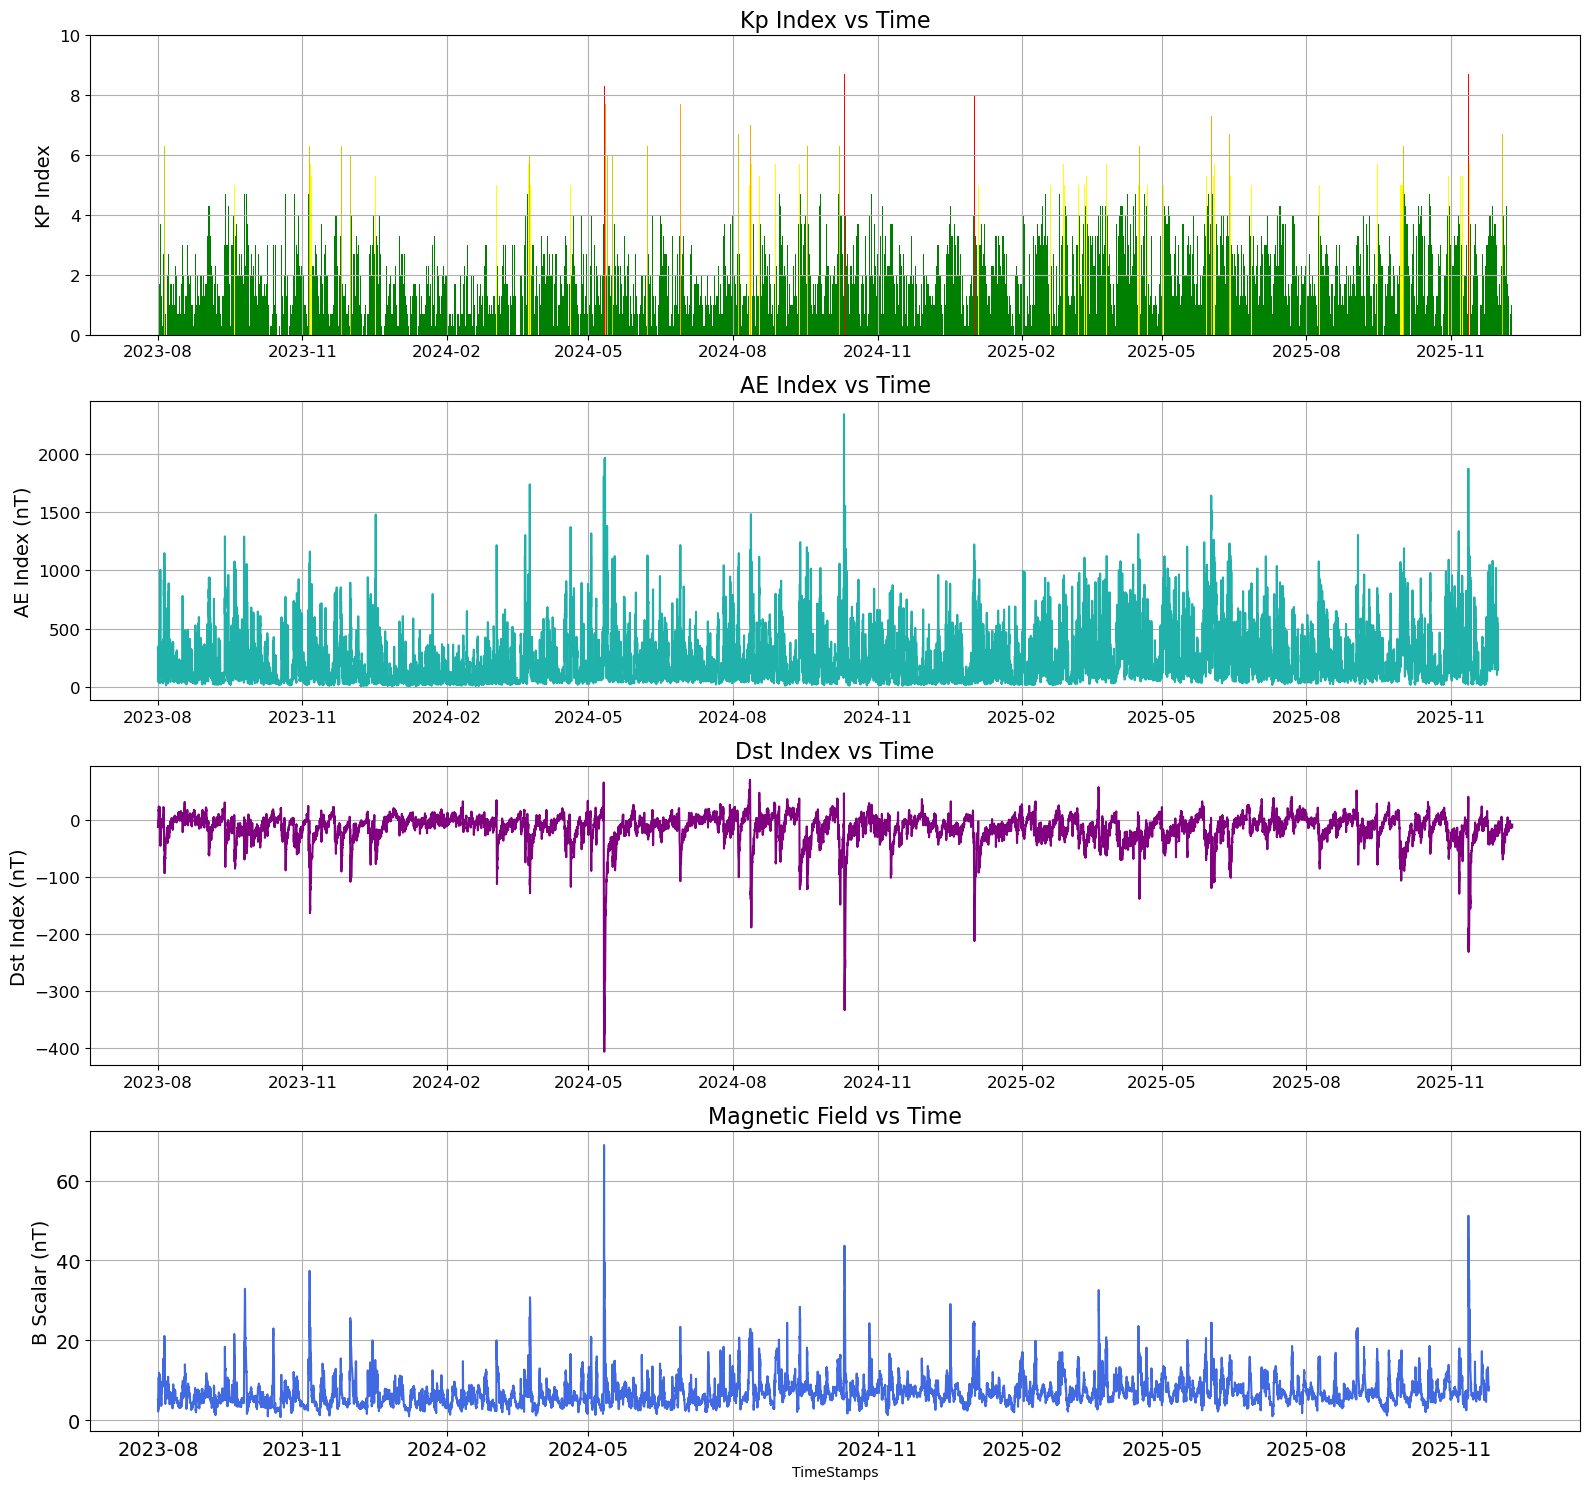

In [52]:
# ALL of 2023 end - 2025 (now) data
omni_data = omni_hr
start_dt = "2023-08-01"
end_dt   = "2025-12-10"

x_tick_vals   = pd.date_range(start=start_dt, end=end_dt, freq="3MS")
x_tick_labels = x_tick_vals.strftime("%Y-%m")

GMActivity_range(omni_data,start_dt,end_dt,x_tick_vals,x_tick_labels,save_fig_str="")

okay now that we have a fire graphic let's just filter thru the days and get someee ranges where we had elev KP!
kP >=5 or the color is yellow. Store timestamps to list, and print the list. 

In [56]:
from collections import defaultdict
from itertools import groupby

daily_ranges = defaultdict(list)
times_sorted = sorted(elev_kp_times)
for date, group in groupby(times_sorted, key=lambda x: x.date()):
    hours = sorted([ts.hour for ts in group])
    
    # Collapse consecutive hours into ranges
    ranges = []
    for k, g in groupby(enumerate(hours), lambda ix: ix[0] - ix[1]):
        group_hours = list(map(lambda x: x[1], g))
        ranges.append((group_hours[0], group_hours[-1]))
    
    daily_ranges[date] = ranges

# Print 
for day, ranges in daily_ranges.items():
    day_str = day.strftime('%Y-%m-%d')
    range_strs = []
    for start, end in ranges:
        if start == end:
            range_strs.append(f"{start:02d}h")
        else:
            range_strs.append(f"{start:02d}h–{end:02d}h")
    print(f"{day_str}: {' , '.join(range_strs)}")

2023-08-05: 00h–08h
2023-09-02: 12h–14h , 21h–23h
2023-09-03: 00h–02h
2023-09-12: 12h–17h
2023-09-18: 15h–20h
2023-09-19: 00h–05h , 12h–17h
2023-09-24: 18h–23h
2023-09-25: 00h–02h
2023-09-26: 12h–14h
2023-10-05: 03h–05h
2023-10-21: 06h–08h
2023-11-05: 09h–20h
2023-11-06: 03h–05h , 18h–20h
2023-11-07: 00h–02h
2023-11-13: 00h–02h
2023-11-22: 03h–08h
2023-11-25: 18h–20h
2023-12-01: 09h–14h , 18h–23h
2023-12-02: 00h–02h
2023-12-17: 12h–17h
2023-12-18: 06h–08h
2024-03-03: 12h–20h
2024-03-23: 21h–23h
2024-03-24: 12h–20h
2024-03-25: 03h–05h
2024-04-16: 18h–23h
2024-04-19: 12h–20h
2024-04-26: 15h–17h
2024-05-02: 12h–20h
2024-05-06: 00h–02h
2024-05-10: 15h–23h
2024-05-11: 00h–23h
2024-05-12: 00h–05h , 21h–23h
2024-05-13: 00h–05h
2024-05-16: 06h–11h
2024-05-17: 15h–23h
2024-06-07: 12h–17h
2024-06-28: 09h–20h
2024-07-26: 03h–05h
2024-07-30: 03h–05h
2024-08-01: 00h–02h
2024-08-04: 12h–17h
2024-08-11: 12h–14h
2024-08-12: 00h–23h
2024-08-17: 15h–23h
2024-08-28: 00h–02h , 06h–08h
2024-09-12: 06h–20h


slay for ae jumps!

In [57]:
AE_threshold = 500  # nT, adjust as needed

large_ae = omni_hr[omni_hr['AE-index, nT'] >= AE_threshold]
ae_times_sorted = sorted(large_ae['TimeStamps'])

daily_ae_ranges = defaultdict(list)

for date, group in groupby(ae_times_sorted, key=lambda x: x.date()):
    hours = sorted([ts.hour for ts in group])
    ranges = []
    for k, g in groupby(enumerate(hours), lambda ix: ix[0] - ix[1]):
        group_hours = list(map(lambda x: x[1], g))
        ranges.append((group_hours[0], group_hours[-1]))
    
    daily_ae_ranges[date] = ranges

for day, ranges in daily_ae_ranges.items():
    day_str = day.strftime('%Y-%m-%d')
    range_strs = []
    for start, end in ranges:
        if start == end:
            range_strs.append(f"{start:02d}h")
        else:
            range_strs.append(f"{start:02d}h–{end:02d}h")
    print(f"{day_str}: {' , '.join(range_strs)}")

2023-08-02: 10h–16h
2023-08-04: 18h–23h
2023-08-05: 00h–06h , 10h–11h
2023-08-07: 02h–03h , 19h–23h
2023-08-08: 00h–01h
2023-08-16: 16h–19h
2023-08-24: 20h
2023-08-26: 15h–16h
2023-08-27: 02h
2023-09-01: 09h
2023-09-02: 03h–15h , 17h–18h , 20h–23h
2023-09-03: 00h , 02h , 06h–07h , 10h
2023-09-05: 16h
2023-09-06: 14h
2023-09-12: 12h–23h
2023-09-13: 00h–01h , 12h , 14h , 16h , 22h
2023-09-14: 01h , 18h–20h
2023-09-16: 20h
2023-09-17: 09h
2023-09-18: 02h–03h , 16h–20h
2023-09-19: 00h–05h , 10h–17h
2023-09-20: 09h–10h , 19h
2023-09-23: 11h–12h
2023-09-24: 20h–23h
2023-09-26: 05h–13h , 15h , 20h
2023-09-29: 06h–07h , 09h–10h
2023-09-30: 14h–23h
2023-10-03: 13h–15h
2023-10-05: 01h–05h
2023-10-18: 13h , 16h–17h , 19h
2023-10-19: 10h
2023-10-20: 20h–23h
2023-10-21: 02h–10h , 12h–14h
2023-10-22: 11h
2023-10-26: 10h–11h , 14h , 20h–21h
2023-10-28: 10h–12h , 14h–15h , 22h–23h
2023-10-29: 00h , 04h , 08h–10h , 14h
2023-10-30: 12h–13h
2023-10-31: 10h
2023-11-04: 18h–20h
2023-11-05: 10h–11h , 15h–21

now for large negative changes in dSt!

In [58]:
# Define threshold for large negative Dst
Dst_threshold = -50  # nT, adjust as needed
large_neg_dst = omni_hr[omni_hr['Dst-index, nT'] <= Dst_threshold]
dst_times_sorted = sorted(large_neg_dst['TimeStamps'])

daily_dst_ranges = defaultdict(list)
for date, group in groupby(dst_times_sorted, key=lambda x: x.date()):
    hours = sorted([ts.hour for ts in group])
    ranges = []
    for k, g in groupby(enumerate(hours), lambda ix: ix[0] - ix[1]):
        group_hours = list(map(lambda x: x[1], g))
        ranges.append((group_hours[0], group_hours[-1]))
    
    daily_dst_ranges[date] = ranges

for day, ranges in daily_dst_ranges.items():
    day_str = day.strftime('%Y-%m-%d')
    range_strs = []
    for start, end in ranges:
        if start == end:
            range_strs.append(f"{start:02d}h")
        else:
            range_strs.append(f"{start:02d}h–{end:02d}h")
    print(f"{day_str}: {' , '.join(range_strs)}")

2023-08-05: 01h , 04h–19h
2023-09-02: 09h–16h
2023-09-12: 17h–23h
2023-09-13: 00h–04h
2023-09-18: 18h–23h
2023-09-19: 00h–16h
2023-09-25: 00h–03h , 05h
2023-09-26: 10h–13h
2023-10-21: 01h–16h
2023-10-28: 10h–12h
2023-10-29: 05h , 08h–11h
2023-11-04: 23h
2023-11-05: 11h–12h , 15h–23h
2023-11-06: 00h–23h
2023-11-07: 00h–10h
2023-11-22: 05h–08h
2023-11-25: 12h , 14h–23h
2023-11-26: 00h–08h
2023-12-01: 11h–23h
2023-12-02: 00h–19h
2023-12-14: 04h–11h
2023-12-17: 12h , 15h–17h
2023-12-18: 08h–09h , 12h–13h
2024-03-03: 16h–23h
2024-03-04: 00h–08h
2024-03-21: 18h–23h
2024-03-22: 01h
2024-03-23: 20h–23h
2024-03-24: 00h–12h , 16h–23h
2024-03-25: 00h–04h , 06h–09h , 12h–23h
2024-03-26: 00h–05h
2024-04-16: 11h–12h , 17h–23h
2024-04-19: 15h–23h
2024-04-20: 00h–10h , 14h–16h
2024-04-21: 08h , 14h–16h , 18h–23h
2024-04-26: 16h
2024-05-02: 16h–21h , 23h
2024-05-03: 00h–01h , 03h–04h
2024-05-10: 19h–23h
2024-05-11: 00h–23h
2024-05-12: 00h–23h
2024-05-13: 00h–19h
2024-05-14: 03h , 10h–12h
2024-05-16: 01

In [61]:
# Combine all timestamps into one set (removes duplicates/overlaps)
all_times = set(elev_kp_times) | set(large_ae['TimeStamps']) | set(large_neg_dst['TimeStamps'])
all_times_sorted = sorted(all_times)

daily_activity = defaultdict(list)

for date, group in groupby(all_times_sorted, key=lambda x: x.date()):
    hours = sorted([ts.hour for ts in group])
    ranges = []
    for k, g in groupby(enumerate(hours), lambda ix: ix[0] - ix[1]):
        group_hours = list(map(lambda x: x[1], g))
        if group_hours[0] == group_hours[-1]:
            ranges.append(f"{group_hours[0]:02d}h")
        else:
            ranges.append(f"{group_hours[0]:02d}h–{group_hours[-1]:02d}h")
    
    daily_activity[date] = ", ".join(ranges)

#DataFrame
activity_df = pd.DataFrame({
    "Date": [day.strftime('%Y-%m-%d') for day in daily_activity.keys()],
    "Active Hours": list(daily_activity.values())
})

activity_df.set_index("Date", inplace=True)
activity_df

,Active Hours
Date,
2023-08-02,10h–16h
2023-08-04,18h–23h
2023-08-05,00h–19h
2023-08-07,"02h–03h, 19h–23h"
2023-08-08,00h–01h
...,...
2025-11-28,"08h, 10h–12h, 14h–16h"
2025-11-29,"07h–08h, 13h–16h"
2025-11-30,"10h, 16h"
